## Gálvez Vigil Manuel
Importamos las librerías.

In [1]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

Importamos la data que vamos a usar.

In [2]:
df =  pd.read_csv('cancun.csv', header=0)
df.set_index('Mes',inplace=True)
df.columns=['valores']
df.index= pd.to_datetime(df.index)

Vemos un poco de información de la base de datos.

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
valores,208.0,41.384615,13.15813,15.0,32.0,39.0,47.0,100.0


Graficamos la serie de tiempo.

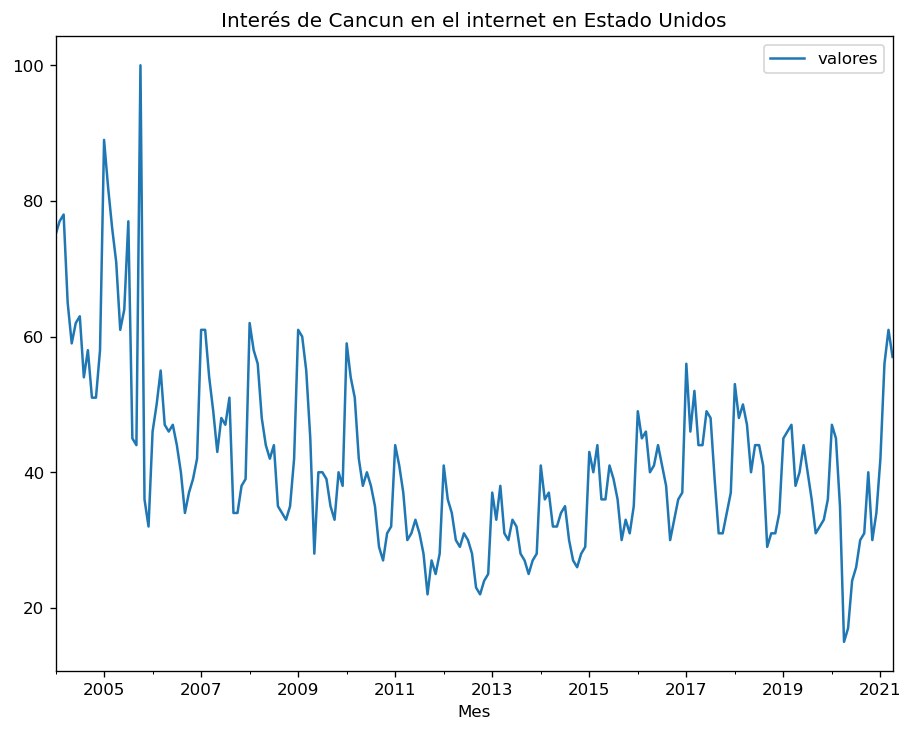

In [4]:
df.plot(title= "Interés de Cancun en el internet en Estado Unidos");

Graficamos la serie de tiempo con la media y la desviación estándar. anual

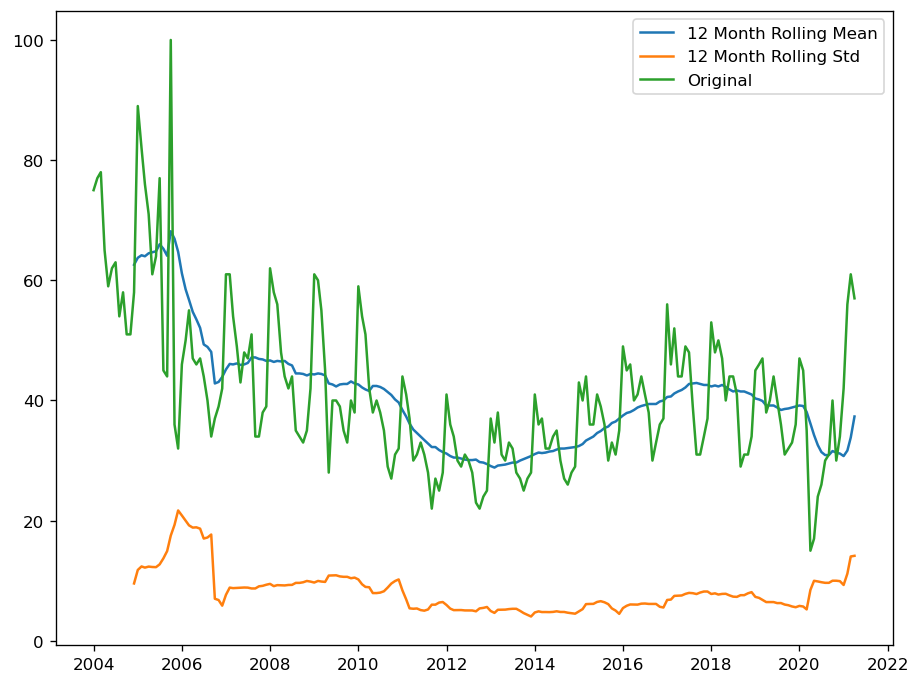

In [5]:
plt.plot(df.rolling(12).mean(), label='12 Month Rolling Mean')
plt.plot(df.rolling(12).std(),label='12 Month Rolling Std')
plt.plot(df, label='Original')
plt.legend()
plt.show()

### 1)
¿La serie de tiempo es estacionaria?¿qué transformación propondrías para hacer la serie estacionaria?<br>
Utilizamos esta función para saber si es estacionario o no con el modelo adfuller.

In [6]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Hacemos nuestras bases con las respectivas transformaciones que queremos aplicar.

In [7]:
df_log = np.log(df) # Transformación Logarítmica
df_dif = df.diff() # Transformación con una diferencia

Nuestra base original es Estacionaria.

In [8]:
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.9787755485491916
p-value : 0.03692460078322258
#Lags Used : 13
Number of Observations Used : 194
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Nuestra transformación con una diferencia es estacionaria.

In [9]:
adf_check(df_dif.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.814954525512156
p-value : 5.0914465724064674e-05
#Lags Used : 12
Number of Observations Used : 194
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


La transformación logarítmica NO es estacionaria.

In [10]:
adf_check(df_log)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.6185999259950314
p-value : 0.08921365088900274
#Lags Used : 13
Number of Observations Used : 194
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Y la transformación logarítmica con una diferencia es estacionaria.

In [11]:
adf_check(df_log.diff().dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.0261529788041654
p-value : 0.0012795909139708811
#Lags Used : 12
Number of Observations Used : 194
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


La transformación con el mejor P-value es la de una diferencia.<br><br>
Graficamos los modelos que son estacionarios.

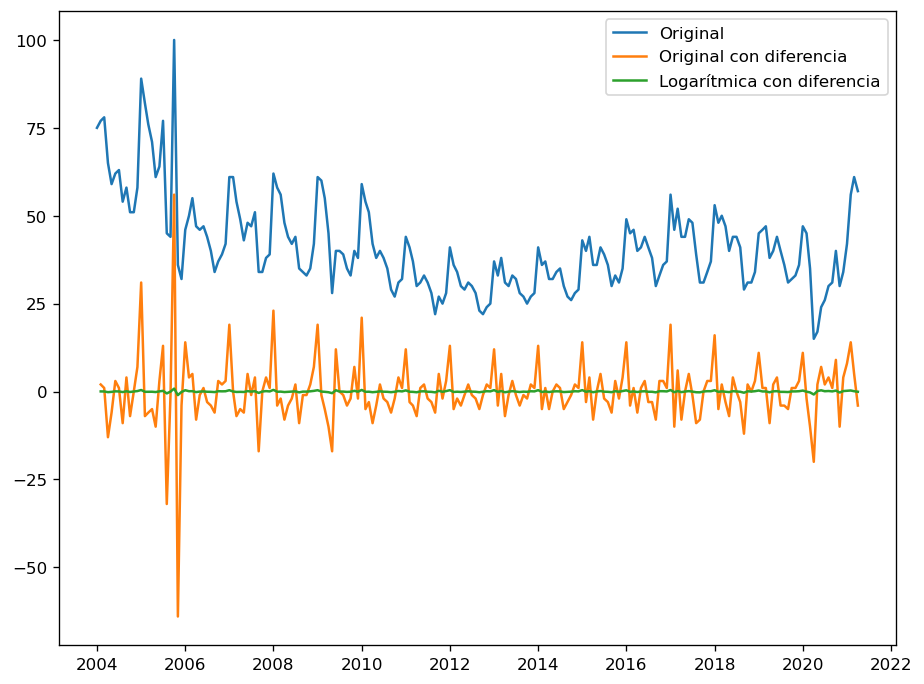

In [12]:
plt.plot(df, label='Original') # Estacionaria
plt.plot(df.diff(), label='Original con diferencia') # Estacionaria
plt.plot(df_log.diff(), label='Logarítmica con diferencia') # Estacionaria
plt.legend()

Utilizamos esta función para tener la serie de tiempo, la tendencia, la gráfica estacional y como se comportan los residuos de nuestra transformación con una diferencia.

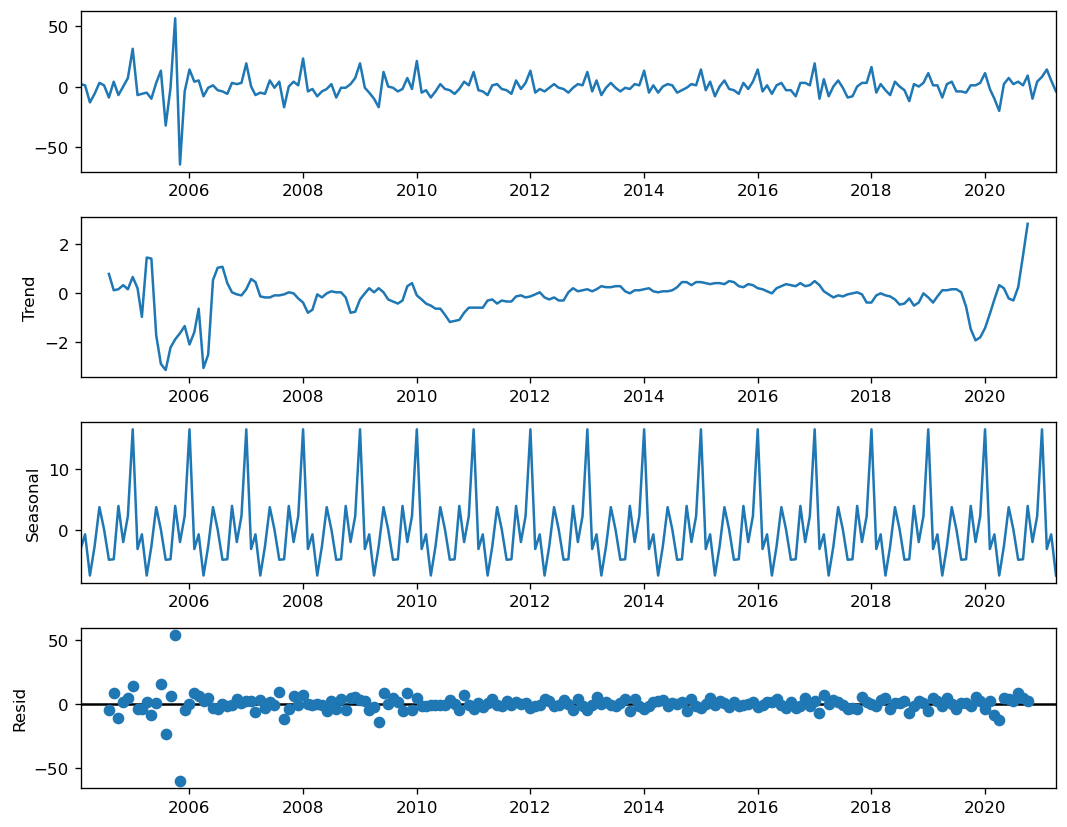

In [13]:
fig = seasonal_decompose(df.diff().dropna()).plot()

### 2)
¿Qué nos dice la ACF y la PACF de la serie original y de sus posibles
transformaciones?<br><br>
Graficamos el ACF y el PACF de la original.

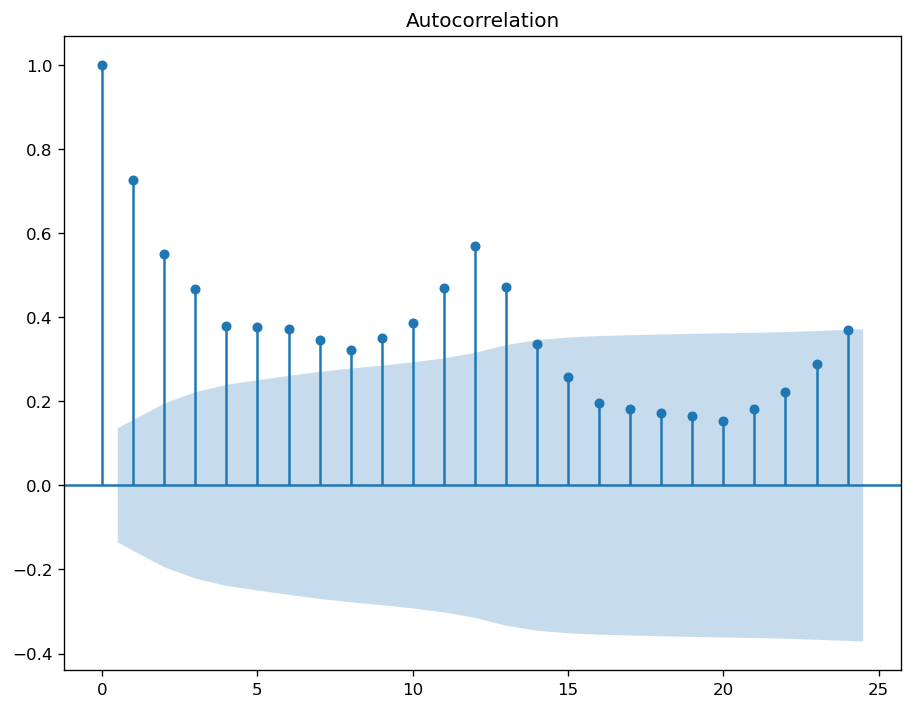

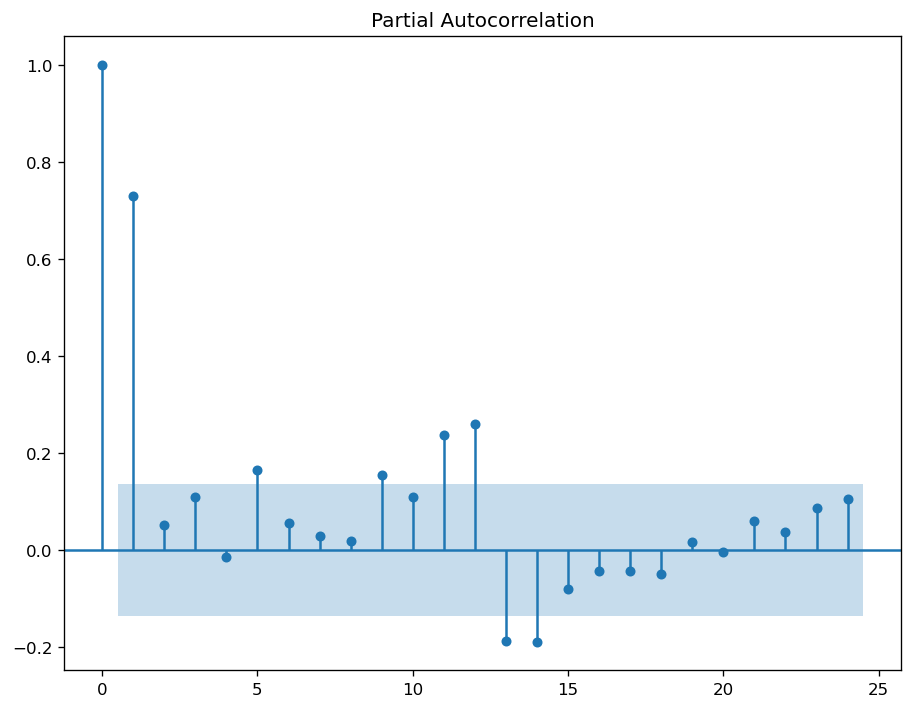

In [14]:
fig = plot_acf(df)
fig = plot_pacf(df)

Graficamos el ACF y el PACF de la transformación con una diferencia.

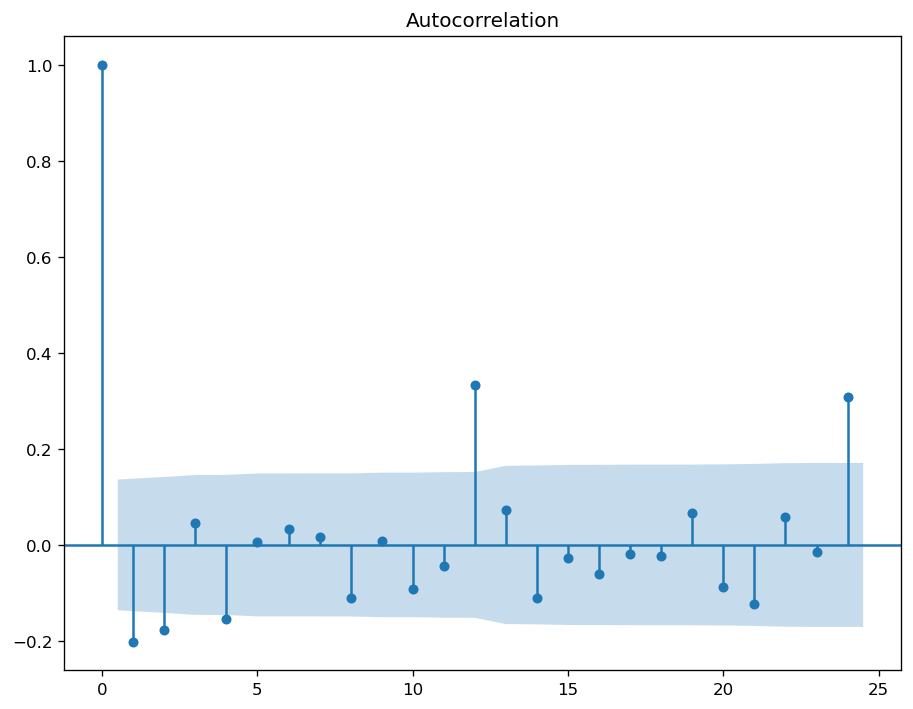

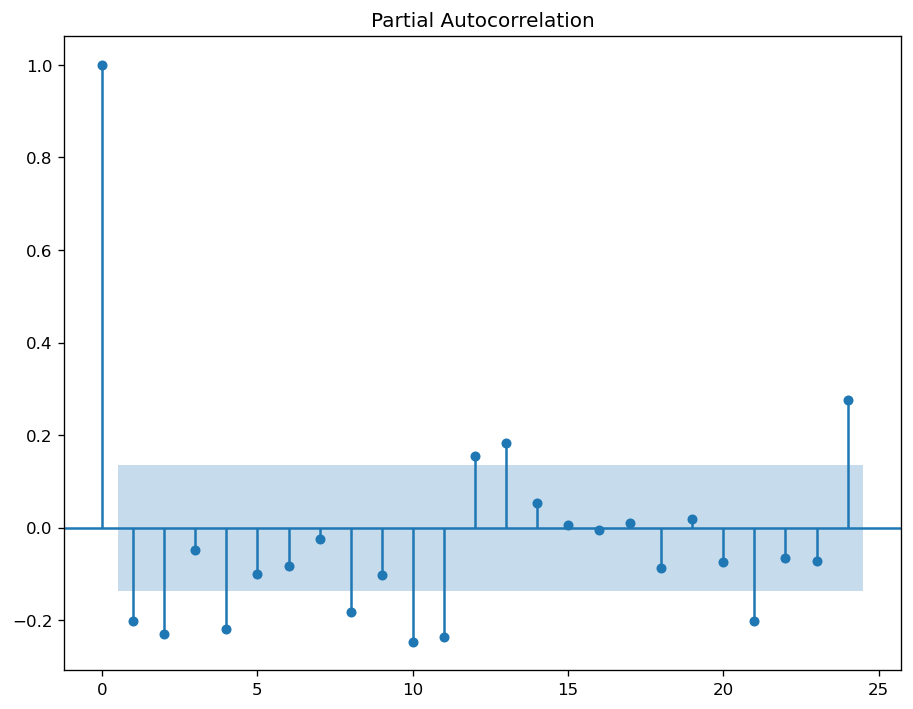

In [15]:
fig = plot_acf(df_dif.dropna())
fig = plot_pacf(df_dif.dropna())

Revisamos que puntos de nuestra ventana del intervalo de confianza en las gráficas del PACF y ACF y vemos cuáles tienen en común, ya que tenemos esos puntos utilizamos el modelo ARMA para ajustar nuestro modelo.

C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

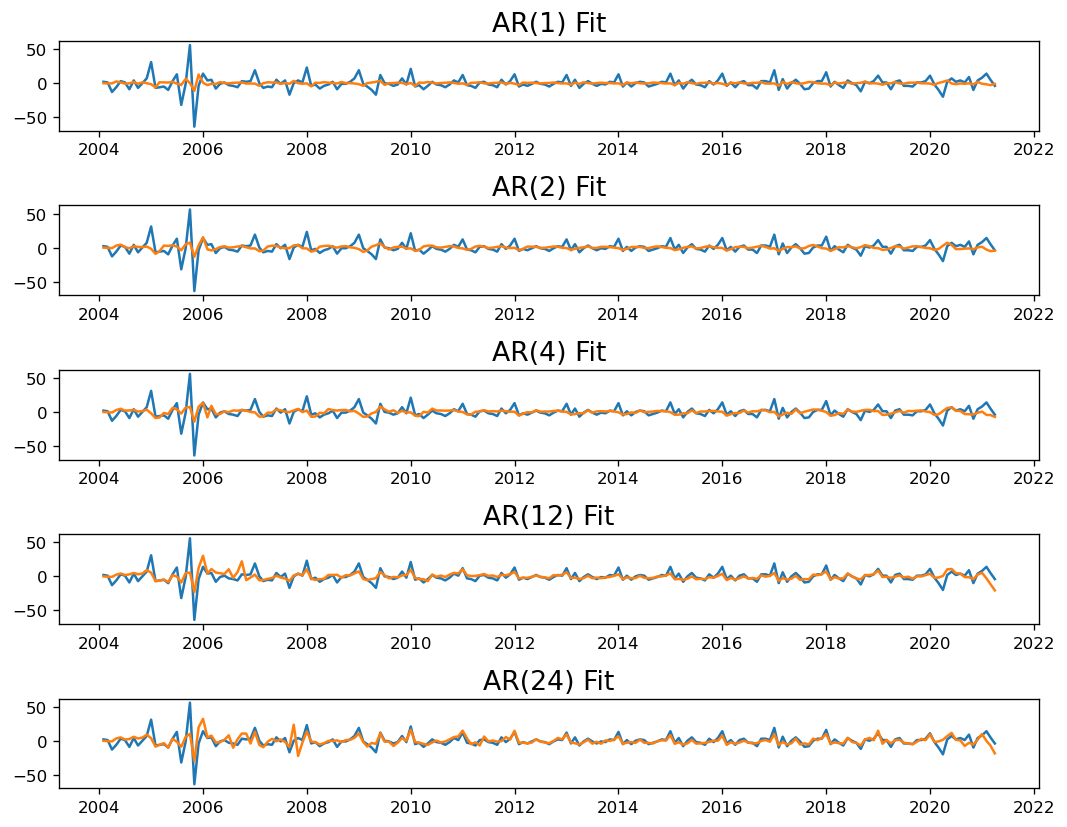

In [16]:
ar_orders = [1,2,4,12,24]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    ar_model = ARMA(df_dif.dropna(), order=(ar_order,0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(5,1,idx+1)
    plt.plot(df_dif.dropna())
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

### 3)
¿Qué modelo le ajustarías a la serie de tiempo? Justifica la elección de tu modelo
(hint: AIC, BIC, MSE,etc...).<br><br>
Aplicamos los modelos de AIC y BIC para saber cuál es el que tiene los valores más bajos.

In [17]:
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 1512.2984947416953
AIC for AR(2): 1503.4592133606488
AIC for AR(4): 1497.1661262734228
AIC for AR(12): 1464.2375156443268
AIC for AR(24): 1453.0045343568636


In [18]:
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 1522.2966511214913
BIC for AR(2): 1516.7900885337103
BIC for AR(4): 1517.162439033015
BIC for AR(12): 1510.895578750042
BIC for AR(24): 1539.6552229817632


Ya que tenemos el mejor punto, en este caso 12, aplicamos el modelo ARIMA para entrenar a nuestro modelo.

In [19]:
model = ARIMA(df, order=(12,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

                             ARIMA Model Results                              
Dep. Variable:              D.valores   No. Observations:                  207
Model:                ARIMA(12, 1, 1)   Log Likelihood                -716.479
Method:                       css-mle   S.D. of innovations              7.649
Date:                Thu, 08 Apr 2021   AIC                           1462.958
Time:                        21:38:48   BIC                           1512.949
Sample:                    02-01-2004   HQIC                          1483.174
                         - 04-01-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0963      0.141     -0.680      0.496      -0.374       0.181
ar.L1.D.valores      0.1933      0.179      1.079      0.281      -0.158       0.544
ar.L2.D.valores     -0.1738 

Graficamos nuestra predicción junto con el modelo original para saber que tanto se aprecen.

C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\manug\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

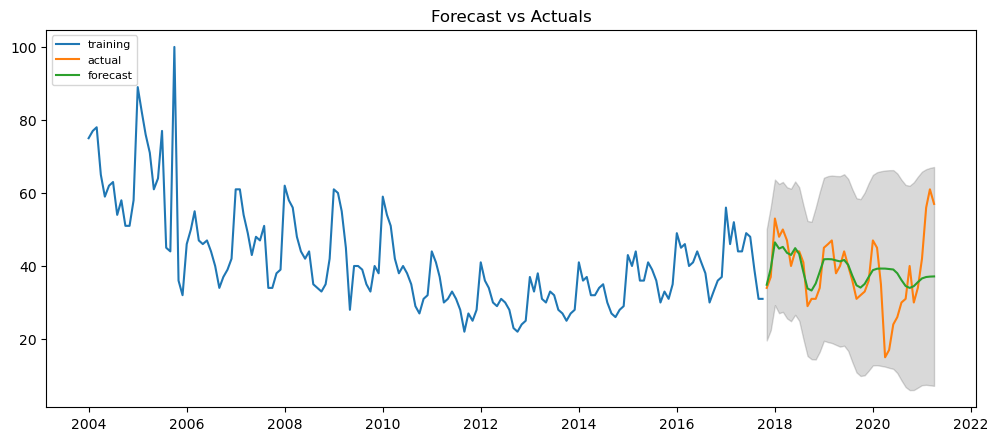

In [20]:
h = 42
# Create Training and Test
train = df.valores[:(208-h)]
test = df.valores[(208-h):]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(12, 1, 1))  
fitted = model.fit(disp=0)  

# Forecast
fc, se, conf = fitted.forecast(h, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4)
Respecto a los errores provenientes del modelo que elegiste, ¿Cómo se comportan?
Justifica si los errores son independientes o están autocorrelados. ¿Dichos errores se
distribuyen normal?<br><br>
Graficamos nuestros errores que tan alejados están de la diagonal.

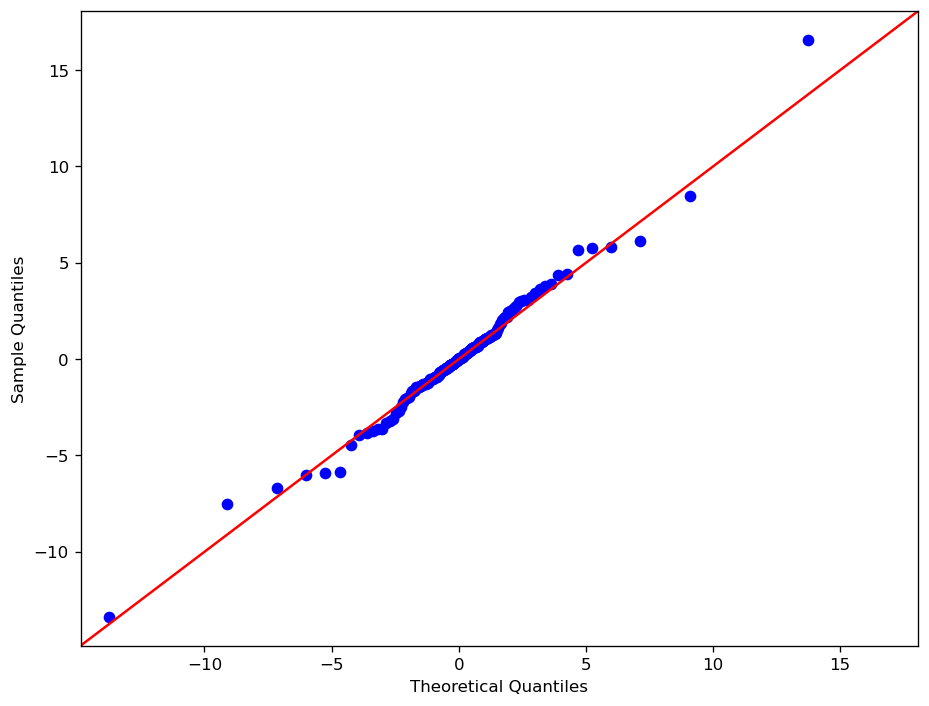

In [21]:
fig = sm.qqplot(model_fit.resid, stats.t, fit=True, line="45")
plt.show()

Vemos que los errores se distribuyen normal.

<AxesSubplot:ylabel='Density'>

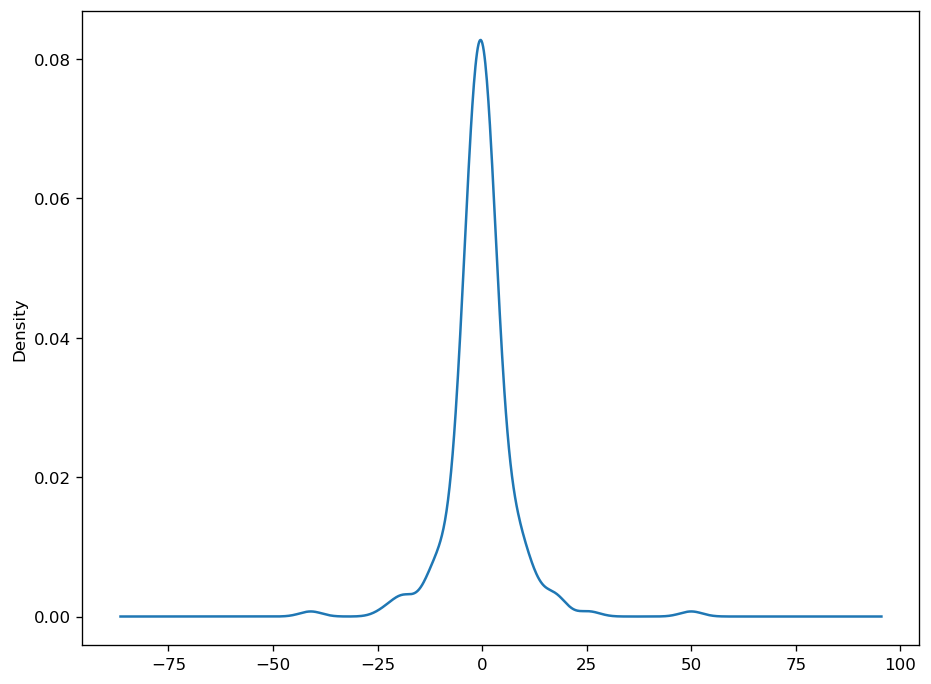

In [22]:
model_fit.resid.plot(kind='kde')

### 5)
¿Qué decisión tomarías respecto a elevar / disminuir el costo de las habitaciones de
hotel en diciembre de este año?<br>
#### Respuesta
Si solo nos fiajmos en los resultados sin saber que se vio afectado por la pandemia diría que se tienen que bajar los precios para que haya más demanda y vuelva a subir, porque se ve que está teniendo un decrecimiento en cuanto a la demanda.<br><br>
Y si sé que esa disminución es debido a la pandemia subiría los precios para que cuando acabe la pandemia y la demanda suba se recuperen las pérdidasque hubo en ese periodo.